In [2]:
import ROOT
import numpy as np
#from root_numpy import random_sample
from scipy.ndimage import uniform_filter
import time
import matplotlib.pyplot as plt
import multiprocessing as mp

Welcome to JupyROOT 6.14/00


<h1>Example simulation</h1>

Simulation of particles and how they compare with noise visually

61

1.0000042332535612 1.0700208431186262


Warning in <TCanvas::Constructor>: Deleting canvas with same name: aaa
Warning in <TROOT::Append>: Replacing existing TH1: randomnumbers (Potential memory leak).


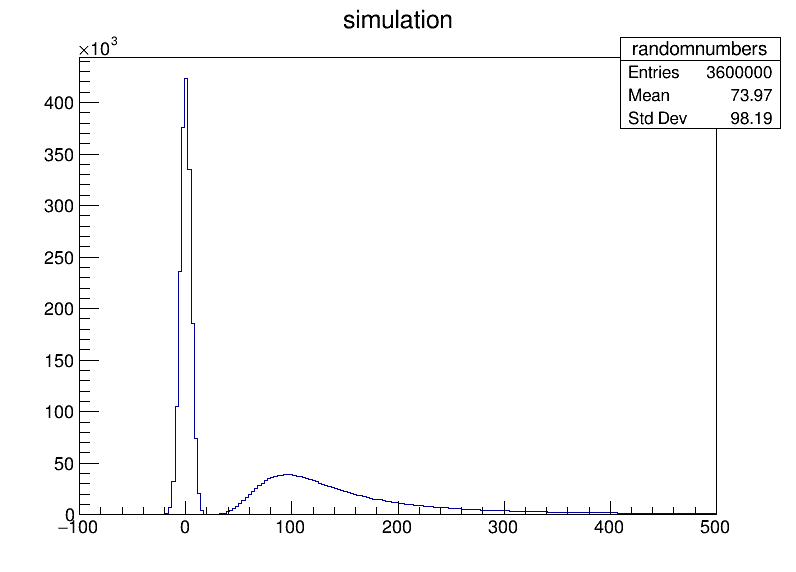

In [6]:
canvas = ROOT.TCanvas("aaa", "bbb", 800, 600)


noise_sigma = 5 # mV
signal_mu = 100 # mV
signal_sigma = 25 # mV

threshold = 20

low = -100
high = 500

fNoise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, 0, %f)" % noise_sigma, low, high)
fNoise.SetNpx(10000)
fSignal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (signal_mu, signal_sigma), low, high)
fSignal.SetNpx(10000)

all_signal = fSignal.Integral(low, high)
all_noise = fNoise.Integral(low, high)

threshold_signal = fSignal.Integral(threshold, high)
threshold_noise = fNoise.Integral(threshold, high)

expected_signal_above = threshold_signal/all_signal
expected_noise_above = threshold_noise/all_noise


nbins = 200
hist = ROOT.TH1F("randomnumbers", "simulation", nbins, low, high)
prng = ROOT.TRandom3(123)

event_count = 3600000
event_ratio = 0.5
signal_count = int(round(event_count * event_ratio))
noise_count = event_count - signal_count

noise_above_count = 0
signal_above_count = 0

for i in range(signal_count):
    signal = prng.Landau(signal_mu, signal_sigma)
    hist.Fill(signal)
    if signal > threshold:
        signal_above_count += 1

for i in range(noise_count):
    noise = prng.Gaus(0, noise_sigma)
    hist.Fill(noise)
    if noise > threshold:
        noise_above_count += 1


print(noise_above_count)


# Här vill jag räkna antalet
print()
print((signal_above_count/expected_signal_above)/signal_count, (noise_above_count/expected_noise_above)/noise_count)

hist.Draw()
canvas.Draw()

====================================================


<h1>Simulation of error in signal estimate  vs. S/B</h1>

As argument it takes: Signal sigma, noise sigma, event ratio, (and event count)


Number of CPU cores to use: 8
C
F


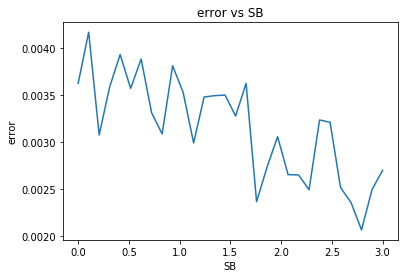

/usr/lib64/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


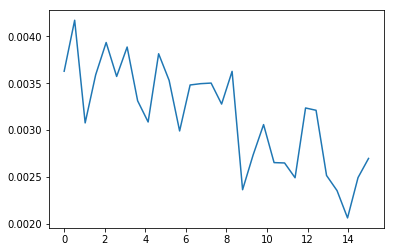

G
37.191417999999885


In [66]:
#event_count = 100000
#event_ratio = 0.5
#noise_sigma = 5
#signal_mu = 100
#signal_sigma = 20
#threshold = 20
#error_of_expected_signal(event_count, event_ratio, signal_mu, signal_sigma, noise_sigma, threshold)
#prng = ROOT.TRandom3(123)


def get_number_above_threshold(threshold, count_, list_):
    arr = np.fromiter(list_, dtype=np.float, count=count_)
    above_count = (arr > threshold).sum()
    return above_count

def error_of_expected_signal(prng, event_count, event_ratio, signal_mu, signal_sigma, noise_sigma, threshold):
    low = -100
    high = 500
    
    # expected
    fNoise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, 0, %f)" % noise_sigma, low, high)
    fNoise.SetNpx(1000)
    fSignal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (signal_mu, signal_sigma), low, high)
    fSignal.SetNpx(1000)

    model_expected_signal_above = 1 - fSignal.Integral(low, threshold)/fSignal.Integral(low, high)
    model_expected_noise_above = 1 - fNoise.Integral(low, threshold)/fNoise.Integral(low, high)
    # threshold_noise / all_noise
    
    
    # simulated
    signal_count = int(round(event_count * event_ratio))
    noise_count = event_count - signal_count

    signal_above_count = 0
    noise_above_count = 0
    

    # like 17% faster, almost not worth it
    signal_iter = [ prng.Landau(signal_mu, signal_sigma) for _ in range(signal_count) ]
    signal_above_count = get_number_above_threshold(threshold, signal_count, signal_iter)

    noise_iter = [ prng.Gaus(0, noise_sigma) for _ in range(noise_count) ]
    noise_above_count = get_number_above_threshold(threshold, noise_count, noise_iter)
    
    
    #det här väret är det vi får reda på från detektorn
    total_above_count = signal_above_count+noise_above_count
    total_count = total_above_count/(event_ratio*model_expected_signal_above + (1-event_ratio)*model_expected_noise_above)
    computed_signal_count = total_count*event_ratio
    deviation = abs(1 - computed_signal_count/signal_count)
    
    #print((signal_above_count/expected_signal_above)/signal_count, (noise_above_count/expected_noise_above)/noise_count)
    
    return deviation


def find_best_threshold_and_error(prng, event_count, event_ratio, signal_mu, signal_sigma, noise_sigma):
    low = 0 # cannot be below 0
    high = 20
    tests = high-low
    
    deviation_iter = [error_of_expected_signal(prng, event_count, event_ratio, signal_mu, signal_sigma, noise_sigma, threshold) for threshold in range(low, high)]
    deviations = np.fromiter(deviation_iter, dtype=np.float, count=tests)
    
    # blur the errors, assumes errors follow a smooth curve, minimum is still minimum.
    size = 5  # default is 3
    deviations_blur = uniform_filter(deviations, size=size)#[1:-1] # nah no need to slice, the boundary error doesn't bother us
    
    # get the minimum
    index = np.argmin(deviations_blur)
    threshold = low + index
    
    # return the best found threshold and the error for it
    #return (threshold, deviations[index])
    return (threshold, deviations_blur[index])
    
    
# Average eller expected ???
def caluclate_SB(expected_signal_energy, noise_sigma):
    return expected_signal_energy/noise_sigma

def calculate_expected_signal_voltage(signal_mu, signal_sigma, reference_signal_mu_for_sigma):
    #low = 0  # There are no particles hitting the detector with negative energies.
    #high = 500
    #fSignalEnergy = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)*x" % (signal_mu, signal_sigma * (signal_mu/reference_signal_mu_for_sigma)), low, high)
    # documents say minimum change if 4 fC - i dunno, just gonna say it is a scale thingy
    #charge = 1 
    #scale = 1 # 0.001 # mili, no sigma is also in mV so it doesn't matter
    #return fSignalEnergy.Integral(low, high) * charge * scale
    return signal_mu
    
    
    
def calculate_average_signal_voltage():
    pass

def linspace(start, end, steps):
    scale = (end-start)/(steps - 1)
    return map(lambda x : start + x*scale, range(steps))

def calculate_SB_array(signal_sigma, noise_sigma, iterator, steps):
    return np.fromiter(
                map(lambda signal_mu :
                        caluclate_SB(
                                #calculate_expected_signal_voltage(signal_mu, signal_sigma), \
                                signal_mu,
                                noise_sigma) ,
                        iterator)
             , dtype=np.float, count=steps)

def calculate_error_array(prng, event_count, event_ratio, signal_sigma, reference_signal_mu_for_sigma, noise_sigma, iterator_data, steps):
    # signal_sigma = 0.5 + signal_sigma * (signal_mu/reference_signal_mu_for_sigma)
    return np.fromiter(
                 map(lambda signal_mu :
                         find_best_threshold_and_error(prng, event_count, event_ratio, signal_mu, 0.5 + signal_sigma * (signal_mu/reference_signal_mu_for_sigma), noise_sigma)[1] ,
                         linspace(*iterator_data))
                 , dtype=np.float, count=steps)

# Single core version
def plot_error_vs_BS(event_count, event_ratio, signal_sigma, reference_signal_mu_for_sigma, noise_sigma):
    min_signal_mu = 0 #mv # cannot be below 0
    max_signal_mu = 20  #mv
    steps = (max_signal_mu - min_signal_mu) * 1
    
    signal_mu_list = list(linspace(min_signal_mu, max_signal_mu, steps))
    SB    = calculate_SB_array(signal_sigma, noise_sigma, linspace(min_signal_mu, max_signal_mu, steps), steps)
    
    seed = 123
    error = calculate_error_array(ROOT.TRandom3(seed), event_count, event_ratio, signal_sigma, reference_signal_mu_for_sigma, noise_sigma, (min_signal_mu, max_signal_mu, steps), steps)
    
    fig = plt.figure()
    plt.title("error vs SB")
    plt.xlabel('SB')
    plt.ylabel('error')
    plt.plot(SB, error)
    plt.show()
    ax = fig.add_subplot(111)
    fig.savefig("SB_error_c"+str(event_count)+".pdf", dpi=200)
    plt.clf()
    plt.plot(signal_mu_list, error)
    plt.show()

# Multi core version
def plot_error_vs_BS_multicore(event_count, event_ratio, signal_sigma, reference_signal_mu_for_sigma, noise_sigma):
    # multi core, set up pool of threads/processes
    max_nprocs = 99  # lower this to like 4 if you like
    nprocs = min(mp.cpu_count(), max_nprocs)
    print(f"Number of CPU cores to use: {nprocs}")
    pool = mp.Pool(processes=nprocs)
    
    # how many steps for each mu to test
    min_signal_mu = 0 #mv # cannot be below 0
    max_signal_mu = 15  #mv
    steps = (max_signal_mu - min_signal_mu) * 2
    
    # setup the x-axis lists
    signal_mu_list = list(linspace(min_signal_mu, max_signal_mu, steps))
    SB = calculate_SB_array(signal_sigma, noise_sigma, linspace(min_signal_mu, max_signal_mu, steps), steps)
    
    seed = 123
    #seed = int(time.time()*1000)
    #prng = ROOT.TRandom3(seed)
    print("C")
    # create argument list
    param_list = [(ROOT.TRandom3(seed + i), event_count, event_ratio, signal_sigma, reference_signal_mu_for_sigma, noise_sigma, (min_signal_mu, max_signal_mu, steps), steps) \
                     for i in range(nprocs)]
    # calculate
    results = pool.starmap(calculate_error_array, param_list)
    error = sum(results)*(1/nprocs)
    pool.close()
    
    # plot
    fig = plt.figure()
    plt.title("error vs SB")
    plt.xlabel('SB')
    plt.ylabel('error')
    
    plt.plot(SB, error)
    print("F")
    plt.show()
    
    ax = fig.add_subplot(111)
    fig.savefig("SB_error_c"+str(event_count)+"M"+str(nprocs)+"_with_dynamic_sigma.pdf", dpi=200)
    plt.clf()
    plt.plot(signal_mu_list, error)
    plt.show()
    print("G")


    
    

def main():
    # estimate: 10^6: 5 hours
    #           10^5: 0.5 hours
    # 500000: 3120 s
    event_count = 400000
    event_ratio = 0.4/4  # = 0.1
    noise_sigma = 5
    #signal_mu = 100
    signal_sigma = 25
    #threshold = 0
    
    # 25 sigma at S1M-2 # s.24
    # mu at 100 # s.15
    reference_signal_mu_for_sigma = 100

    #error_of_expected_signal(event_count, event_ratio, signal_mu, signal_sigma, noise_sigma, threshold)
    #find_best_threshold_and_error(event_count, event_ratio, signal_mu, signal_sigma, noise_sigma)
    t0 = time.clock()
    plot_error_vs_BS_multicore(event_count, event_ratio, signal_sigma, reference_signal_mu_for_sigma, noise_sigma)
    t1 = time.clock()
    print(t1-t0)



if __name__ == '__main__':
    mp.freeze_support()
    main()

